
# We seek to build a generic architecture to model an epithelium.

<hr/>

## Documentation

### Boost

* [Official boost.python  documentation](http://www.boost.org/doc/libs/1_58_0/libs/python/doc/index.html)
* [Boost.python on python wiki](https://wiki.python.org/moin/boost.python/HowTo)
* [Workshop at scipy 2014 on boost-python](https://github.com/jcfr/scipy2014_boost_python_workshop_student_material)
* [Neet mingling of boost::python in an IPython notebook](https://github.com/abingham/boost_python_tutorial)


The `graph_tool` library is a very good example of higly efficient, complete and complex boost based python library: 
* [graph-tool source code](https://git.skewed.de/count0/graph-tool/tree/master)

### CGAL
* [CGAL documentation](http://doc.cgal.org)
* [CGAL Polyhedron](http://doc.cgal.org/latest/Polyhedron/index.html)
* [CGAL LinearCellComplex](http://doc.cgal.org/latest/Linear_cell_complex/group__PkgLinearCellComplex.html)
* [CGAL CombinatorialMap](http://doc.cgal.org/latest/Combinatorial_map/index.html#ChapterCombinatorialMap)



## Models we want to simulate

The first model that will be implemented is the one described in
Monier et al. [monier2015apico]. It is an example of a vertex model,
where the interactions are only evaluated on the apical surface sheet
of the epithelium. The second class of models are still at an
stage. They implement a description of the tissue's rheology, within a
dissipation function formalism.

![Examples of possible models](../../doc/illus/two_models.png)

## Class diagram

The graphic below details the various objects modeled here. Each of those are implemented as an abstract class. If one considers the model in Monier et al. [monier2015apico], the apical sheet is consituted of vertices and edges, representing apical junctions. This geometry can be generalized to model 3D columnar cells constituted of apical, basal and equatorial meshes, linked by sagital edges. Depending on the model, a subset of those junctions will be used. Each cell interacts with its neighbour through its junctions. An epithelium is then a graph of interacting cells, with two cells neighbouring cells sharing a junction.

There are two interesting libraries to deal with the objects we whish to consider. The first one, [`CGAL::Polyhedron`](http://doc.cgal.org/latest/Polyhedron/index.html) can only represent surfaces, and can't be used for the general 3D tissue. The second one, [`CGAL::LinearCellComplex`](http://doc.cgal.org/latest/Linear_cell_complex/group__PkgLinearCellComplex.html) is suited for all our models. The `Polyhedron` model is simpler though, and there's a [function](http://doc.cgal.org/latest/Linear_cell_complex/group__PkgLinearCellComplexConstructions.html#ga9239e988c6d5e674d64438d47b95a548) that can create `LCC` objects form `Polyhedron` instances. In order to ease the porting of the `leg-joint` simulations to the new architecture, we'll first develop this model within the `Polyhedron` framework, and then generalized with the LCC.

### `Polyhedron` class diagramm

Here is a representation of the data structure defined by the `CGAL::Polyhedron` data structure:

![Definition of a polyedron_3 data structure from CGAL's doc](http://doc.cgal.org/latest/Polyhedron/halfedge_small.png)

When modeling an epithelium sheet (apical, basal or sagital), there is a direct equivalence between:

* Junction vertex and Vertex 
* Junction edge and Edge (represented by two halfedges)
* Facet and cell

![Class diagram for polyhedron](../../doc/illus/class_diagramm_poly.png)




### `LCC` class diagramm


All the physical objects are represented by CGAL Linear Cell Complexes - in short LCC, that are specialized versions of CGAL Combinatorial Maps. Vertices are 0-cells (associated to a Point object in the LCC), edges 1-cells, faces are 2-cells and volumes are 3-cells [1]. With this concept, individual cells as well as the whole epithelium are represented by a LCC. As can be seen by browsing the above linked documentations, this very general framework provides efficient ways to represent the tissue and common events such as cell division (using lcc.insert_point_in_cell). For a given model, only subsets of these objects might be needed, but we'll try to keep the various definitions as generic as possible, for example by defining cell division irrespective of the detailed geometry of the cell, through template meta-programming


![Class diagram](../../doc/illus/class_diagram.png)
_Not meant to be ULM compliant_


Note that we might need to further sub-class CGAL's LinearCellComplex to take into account the possibility of curved edges and faces in the vertex rheology models.

### LinearCellComplex in CGAL

In CGAL, the LinearCellComplex defines linear oriented nD objects. In 2D, this representation is equivalent to the [HalfEdge data structure](http://doc.cgal.org/latest/HalfedgeDS/index.html#chapterHalfedgeDS) and could be implemented as [Polygon_3](http://doc.cgal.org/latest/Polyhedron/group__PkgPolyhedron.html). The advantage of LCC over halfedges is it's extensibility to 3 dimentions and dimention agnostic aspects.

![Schematic of a CGAL LCC](http://doc.cgal.org/latest/Linear_cell_complex/lcc-examples-2d-3d.png)

As a LCC is a CombinatorialMap, and as such is **edge centered**. A combinatorial map is a set of **darts** linking all its elements. The concept of darts and $\beta_i$ pointers is discussed at length in CGAL documentation. We will mainly use them to define custom iterators over the various elements of our tissues. 

#### Over libraries of interest in CGAL

* [Boost property maps](http://doc.cgal.org/latest/Property_map/index.html)
* [I/O](http://doc.cgal.org/latest/Stream_support/index.html#Chapter_IO_Streams). We might prefer to
  defer I/O to python, though.


## Definitions of the building blocks

The sketch below details the overall tissue organisation, and the different building blocks a tissue is composed of.

![Objects architecture](../../doc/illus/objects_architecture.png)

Note that the vertex called "cell vertex" and the "cell to junction" edges are an oversegmentation of the tissue, that might be usefull to compute geometrical properties or for visualisation (as a mesh). Actual cells can be represented by a single n-cell LCC, or a combination of n-cells LCC, where n is the tissue dimention (n is 2 for a sheet, 3 for a volume).


###  Notations


| Object   | index notation  | iterator notation  |
| -------- | ---------------- | ------------------- |
| Junction vertex | $jv^a_i$ | $i = {0, \cdots, N_{ajv}}$ |
| Bulk vertex | $bv^a_\alpha$  | $\alpha = {0, \cdots, N_{c}}$  |
| Junction edge | $je^a_{ij}$ | $i,j / j \neq i, (i, j) \in C(i)$ |

Here $C(i)$ is the set of junction edges going out of vertex $i$. The superscript $a$ stends for apical.

### Project file structure

* [tyssue project](../../)
    - [notebooks](../)
        * sympy _Models implementation in sympy_
        * core-architecture _Technical documentation of the project implementation_
        * simulations _Documentation of the python frontend_
    - [illus](../../illus) _Sketches and illustrations_
    - [src](../../src) _The source code_
        * cpp-tyssue _C++ files_
        * tyssue _Python bindings_
        

## Python implementation of the class structure



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline


### Data format

Linear Cell complexes in CGAL can be constructed from a graph input as `std::istream & ais`. [From the docs](http://doc.cgal.org/latest/Linear_cell_complex/group__PkgLinearCellComplexConstructions.html#gaa356d78601f8844476fc2e039f0df83e)):


>The file format must be the following. First the number of vertices and the number of edges of the planar graph. Then, for each vertex of the planar graph, the coordinates of the $i^{th}$ vertex (two numbers for x and y coordinates). The first vertex index is 0. Then for each edge of the planar graph, the two indices of the two vertices (two numbers between 0 and the number of vertices minus 1).


Let's see if we can reproduce this format from nd arrays


### Minimal epithelium

For now, we'll mimick the CGAL component by hand for a minimal epithelium pictured below:

![Minimal 2D Epithelium](../../doc/illus/minimal_eptm_2D.svg)



In [2]:
Nc = 3 # Number of cells

points = np.array([[0., 0.],
                   [1.0, 0.0],
                   [1.5, 0.866],
                   [1.0, 1.732],
                   [0.0, 1.732],
                   [-0.5, 0.866],
                   [-1.5, 0.866],
                   [-2, 0.],
                   [-1.5, -0.866],
                   [-0.5, -0.866],
                   [0, -1.732],
                   [1, -1.732],
                   [1.5, -0.866]])

edges = np.array([[0, 1],
                  [1, 2],
                  [2, 3],
                  [3, 4],
                  [4, 5],
                  [5, 0],
                  [5, 6],
                  [6, 7],
                  [7, 8],
                  [8, 9],
                  [9, 0],
                  [9, 10],
                  [10, 11],
                  [11, 12],
                  [12, 1]])

Nv, Ne = len(points), len(edges)


/home/guillaume/anaconda/envs/python3/lib/python3.4/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


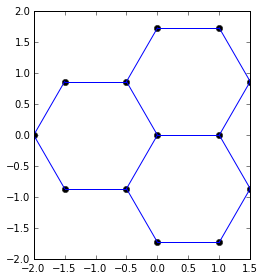

In [3]:

fig, ax = plt.subplots()

ax.plot(points[:, 0], points[:, 1], 'ko')

for s, t in edges:
    ax.plot([points[s, 0], points[t, 0]],
            [points[s, 1], points[t, 1]], 'b-')
ax.set_aspect('equal')


#### From that it's pretty easy to print the `ais` string refered above:

[Numpy print options](http://docs.scipy.org/doc/numpy/reference/generated/numpy.set_printoptions.html) might be usefull here. 

Also relevant: [a discussion of `std::istream` and `boost::python`](http://stackoverflow.com/questions/24225442/converting-python-io-object-to-stdistream-when-using-boostpython)

In [33]:

def ais_string(points, edges):
    ais = '\n'.join(
        ['{} {}'.format(Nv, Ne), 
         ' '.join(['{} {}'.format(x, y) for (x, y) in points]),
         ' '.join(['{} {}'.format(srce, trgt) for (srce, trgt) in edges])
        ])

    return ais

print('ais string:\n')
print(ais_string(points, edges))

def off_string(points, edges):
    '''
    Line 1
        OFF
    Line 2
        vertex_count face_count edge_count
    One line for each vertex:
        x y z
        for vertex 0, 1, ..., vertex_count-1
    One line for each polygonal face:
        n v1 v2 ... vn,
        the number of vertices, and the vertex indices for each face. 
    '''

    off_str = 'OFF\n'
    off_str += '{} {} {}\n'.format(Nv, Nc, Ne)
    for p in points:
        off_str +='{} {} 0\n'.format(p[0], p[1])
    off_str += '6 0 1 2 3 4 5\n'
    off_str += '6 0 5 6 7 8 9\n'
    off_str += '6 0 9 10 11 12 1\n'
    
    return off_str
    
print('OFF string:\n')
print(off_string(points, edges))

ais string:

13 15
0.0 0.0 1.0 0.0 1.5 0.866 1.0 1.732 0.0 1.732 -0.5 0.866 -1.5 0.866 -2.0 0.0 -1.5 -0.866 -0.5 -0.866 0.0 -1.732 1.0 -1.732 1.5 -0.866
0 1 1 2 2 3 3 4 4 5 5 0 5 6 6 7 7 8 8 9 9 0 9 10 10 11 11 12 12 1
OFF string:

OFF
13 3 15
0.0 0.0 0
1.0 0.0 0
1.5 0.866 0
1.0 1.732 0
0.0 1.732 0
-0.5 0.866 0
-1.5 0.866 0
-2.0 0.0 0
-1.5 -0.866 0
-0.5 -0.866 0
0.0 -1.732 0
1.0 -1.732 0
1.5 -0.866 0
6 0 1 2 3 4 5
6 0 5 6 7 8 9
6 0 9 10 11 12 1



#### Core indexes



In [5]:
cell_idx = pd.Index(range(Nc), name='cell')
jv_idx = pd.Index(range(Nv), name='jv')

### We'll rely on CGAL for this, of course, but a by-hand test case
### won't be wasted
_je_idx = [(0, 1, 0),
           (1, 2, 0),
           (2, 3, 0),
           (3, 4, 0),
           (4, 5, 0),
           (5, 0, 0),
           (0, 5, 1),
           (5, 6, 1),
           (6, 7, 1),
           (7, 8, 1),
           (8, 9, 1),
           (9, 0, 1),
           (0, 9, 2),
           (9, 10, 2),
           (10, 11, 2),
           (11, 12, 2),
           (12, 1, 2),
           (1, 0, 2)]

je_idx = pd.MultiIndex.from_tuples(_je_idx, names=['srce', 'trgt', 'cell'])

### Cell - cell graph
cc_idx = pd.MultiIndex.from_tuples([(0, 1), (1, 2), (2, 3)],
                                    names=['cell_a', 'cell_b'])


###  Core data

In [27]:
### Cells DataFrame
cell_df = pd.DataFrame(index=cell_idx, 
                       columns=['area', 'age', 'x', 'y'])
cell_df['age'] = 0

### Junction vertices DataFrame
jv_df = pd.DataFrame(points, index=jv_idx,
                     columns=['x', 'y'])

### Junction edges DataFrame
je_df = pd.DataFrame(index=je_idx,
                     columns=['dx', 'dy', 'u']) # u carries the norm

In [43]:
cc_idx = []
for srce0, trgt0, cell0 in je_idx:
    for srce1, trgt1, cell1 in je_idx:
        if (cell0 != cell1 
            and trgt0 == srce1
            and trgt1 == srce0
            and not (cell1, cell0) in cc_idx):
            cc_idx.append((cell0, cell1))
cc_idx = pd.MultiIndex.from_tuples(cc_idx, names=['cella', 'cellb'])

### Toy computations

Below we show some examples of geometrical computing.


In [30]:
srce_idx = je_idx.get_level_values('srce')
trgt_idx = je_idx.get_level_values('trgt')
e_cell_idx = je_idx.get_level_values('cell')

je_df[['dx', 'dy']] = (jv_df.loc[trgt_idx][['x', 'y']].values
                      - jv_df.loc[srce_idx][['x', 'y']].values)

je_df['length'] = np.hypot(je_df['dx'], je_df['dy'])
np.testing.assert_allclose(je_df['length'], 1, rtol=1e-3)

## Let's take the edge source positions for each edge
## That's upcasting from source to edges
upcast_pos = jv_df.loc[srce_idx][['x', 'y']]
upcast_pos.set_index(je_idx, inplace=True)

## Now it's easy to compute the centroid of each cell
cell_df[['x', 'y']] = upcast_pos.groupby(level='cell').mean()

## the area is trickier, let's first get the normals

je_df['n'] = np.cross(jv_df.loc[srce_idx][['x', 'y']].values
                      - cell_df[['x', 'y']].loc[e_cell_idx].values,
                      jv_df.loc[trgt_idx][['x', 'y']].values
                      - cell_df[['x', 'y']].loc[e_cell_idx].values)
## Now the area
cell_df['area'] = np.abs(je_df['n']).groupby(level='cell').sum()
np.testing.assert_allclose(je_df['length'], 1, rtol=1e-3)


In [29]:
cell_df

,area,age,x,y
cell,,,,
0,5.196,0,0.5,0.866
1,5.196,0,-1.0,0.000
2,5.196,0,0.5,-0.866


In [22]:

def parse(source):
    raise NotImplementedError

class Epithelium:
    '''
    The whole tissue.
    
    '''
    def __init__(self, identifier, 
                 cell_df, jv_df, je_df):
        '''
        Creates an epithelium
        
        
        '''
        self.identifier = identifier
        self.cell_df = cell_df
        self.jv_df = jv_df
        self.je_df = je_df
        
    @property
    def cell_idx(self):
        return self.cell_df.index
    
    @property
    def jv_idx(self):
        return self.jv_df.index

    @property
    def je_idx(self):
        return self.je_df.index
    
    @property
    def cc_idx(self):
        return self._build_cell_cell_indexes()
        
    def _build_cell_cell_indexes(self):
        '''
        This is hackish and not optimized,
        should be provided by CGAL
        '''
        cc_idx = []
        for srce0, trgt0, cell0 in self.je_idx:
            for srce1, trgt1, cell1 in self.je_idx:
                if (cell0 != cell1 
                    and trgt0 == srce1
                    and trgt1 == srce0
                    and not (cell1, cell0) in cc_idx):
                    cc_idx.append((cell0, cell1))
        cc_idx = pd.MultiIndex.from_tuples(cc_idx, names=['cella', 'cellb'])
        return cc_idx
        
    @classmethod
    def from_file(cls, input_file, identifier):
        '''
        Creates an `Epithelium` instance from parsing an input file
        
        '''
        with open(input_file, 'r') as source:
            input_data = parse(source)
            return cls.__init__(identifier, *input_data)
        
    
    
    

class Cell:
    
    def __init__(self, eptm, index):
        
        self.id = index #from CGAL
        
    def jv_orbit(self):
        '''
        Sequence of the indexes of the cell's
        junction vertices.       
        
        '''
        pass
        
    def je_orbit(self):
        '''
        Sequence of the indexes of the cell's
        junction halfedges.       
        
        '''
        pass        
        
    @property
    def num_sides(self):
        
        return len(self.je_orbit())
        
    
        
        
class JunctionVertex:
    
    def __init__(self, index, point):
        
        self.id = index #from CGAL
        self.point = point #from CGAL ?
    
    def cell_orbit(self):
        '''
        Sequence of indexes of the neighboring cells
        '''
        pass 

    def edge_orbit(self):
        '''
        Sequence of indexes of the neighboring junction edges, returned
        as the indexes of the **outgoing** halfedges. 
        '''
        pass
        
    
    
        
        
class JunctionEdge(LinearCellComplex):
    
    def __init__(self):

class Facet(LinearCellComplex):
    
    def __init__(self):
        LinearCellComplex.__init__(self, 2)

class Volume(LinearCellComplex):
    
    def __init__(self):
        LinearCellComplex.__init__(self, 3)

        
class Cell(LinearCellComplex):
    
    def __init__(self, dim):
        LinearCellComplex.__init__(self, dim)


    @property
    def j_edges(self):
        '''
        Iterate over the junction edges
        '''
        for je in self._jnct_edges:
            yield je

        
    @property
    def faces(self):
        '''
        Iterate over the faces
        '''
        for face in self._faces:
            yield face
        